In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
import os

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d andrewmvd/drive-digital-retinal-images-for-vessel-extraction

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction
License(s): other
  0% 0.00/28.0M [00:00<?, ?B/s]
100% 28.0M/28.0M [00:00<00:00, 968MB/s]


In [11]:
!unzip drive-digital-retinal-images-for-vessel-extraction.zip

Archive:  drive-digital-retinal-images-for-vessel-extraction.zip
  inflating: DRIVE/test/images/01_test.tif  
  inflating: DRIVE/test/images/02_test.tif  
  inflating: DRIVE/test/images/03_test.tif  
  inflating: DRIVE/test/images/04_test.tif  
  inflating: DRIVE/test/images/05_test.tif  
  inflating: DRIVE/test/images/06_test.tif  
  inflating: DRIVE/test/images/07_test.tif  
  inflating: DRIVE/test/images/08_test.tif  
  inflating: DRIVE/test/images/09_test.tif  
  inflating: DRIVE/test/images/10_test.tif  
  inflating: DRIVE/test/images/11_test.tif  
  inflating: DRIVE/test/images/12_test.tif  
  inflating: DRIVE/test/images/13_test.tif  
  inflating: DRIVE/test/images/14_test.tif  
  inflating: DRIVE/test/images/15_test.tif  
  inflating: DRIVE/test/images/16_test.tif  
  inflating: DRIVE/test/images/17_test.tif  
  inflating: DRIVE/test/images/18_test.tif  
  inflating: DRIVE/test/images/19_test.tif  
  inflating: DRIVE/test/images/20_test.tif  
  inflating: DRIVE/test/mask/01_tes

In [12]:
base_path = "/content/DRIVE/training"
image_path = os.path.join(base_path, "images")
gt_path = os.path.join(base_path, "1st_manual")
mask_path = os.path.join(base_path, "mask")

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    green = img[:,:,1]
    green = cv2.GaussianBlur(green, (5,5), 0)
    return green

In [14]:
from skimage.filters import threshold_niblack, threshold_sauvola

#Niblack
def apply_niblack(img):
    thresh = threshold_niblack(img, window_size=25, k=-0.2)
    return (img < thresh).astype(np.uint8)

#Sauvola
def apply_sauvola(img):
    thresh = threshold_sauvola(img, window_size=25, k=0.2)
    return (img < thresh).astype(np.uint8)

In [15]:
def sensitivity(pred, gt):
    tp = np.sum((pred == 1) & (gt == 1))
    fn = np.sum((pred == 0) & (gt == 1))
    return tp / (tp + fn + 1e-6)

In [16]:
from skimage.morphology import skeletonize

def get_thin_vessels(gt):
    return skeletonize(gt > 0).astype(np.uint8)

In [17]:
print(os.listdir(image_path)[:5])
print(os.listdir(gt_path)[:5])

['28_training.tif', '35_training.tif', '21_training.tif', '25_training.tif', '30_training.tif']
['30_manual1.gif', '29_manual1.gif', '34_manual1.gif', '33_manual1.gif', '24_manual1.gif']


In [18]:
from tqdm import tqdm

niblack_sens = []
sauvola_sens = []

image_files = sorted(os.listdir(image_path))
gt_files = sorted(os.listdir(gt_path))

for img_name in tqdm(image_files):

    img_id = img_name.split("_")[0]

    gt_name = f"{img_id}_manual1.gif"

    img = preprocess_image(os.path.join(image_path, img_name))
    gt = cv2.imread(os.path.join(gt_path, gt_name), 0)

    if gt is None:
        print("Missing GT for:", img_name)
        continue

    gt = (gt > 127).astype(np.uint8)
    thin_gt = get_thin_vessels(gt)

    nib_mask = apply_niblack(img)
    sau_mask = apply_sauvola(img)

    # Sensitivity
    niblack_sens.append(sensitivity(nib_mask, thin_gt))
    sauvola_sens.append(sensitivity(sau_mask, thin_gt))


print("\n")
print("Niblack Sensitivity:", np.mean(niblack_sens))
print("Sauvola Sensitivity:", np.mean(sauvola_sens))

100%|██████████| 20/20 [00:01<00:00, 11.16it/s]



Niblack Sensitivity: 0.9203964957748332
Sauvola Sensitivity: 0.1059744293612404


In [19]:
print(f"Niblack Sensitivity: {np.mean(niblack_sens):.4f}")
print(f"Sauvola Sensitivity: {np.mean(sauvola_sens):.4f}")

Niblack Sensitivity: 0.9204
Sauvola Sensitivity: 0.1060


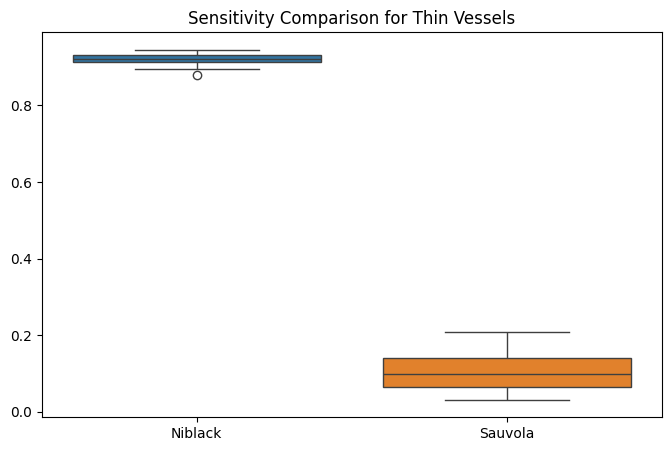

In [20]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=[niblack_sens, sauvola_sens])
plt.xticks([0,1], ["Niblack", "Sauvola"])
plt.title("Sensitivity Comparison for Thin Vessels")
plt.show()

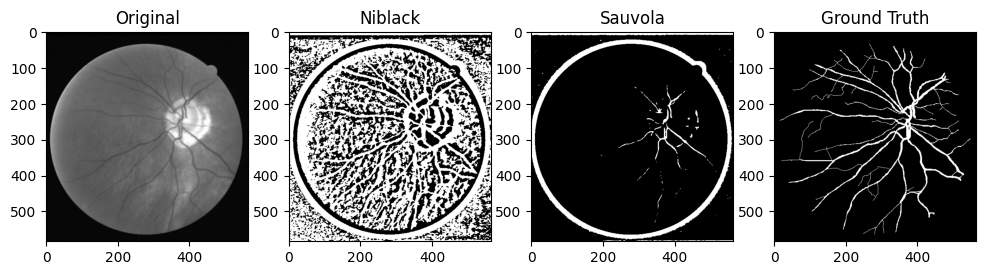

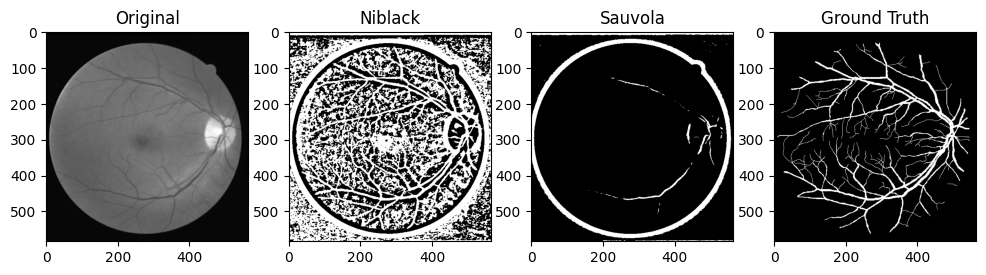

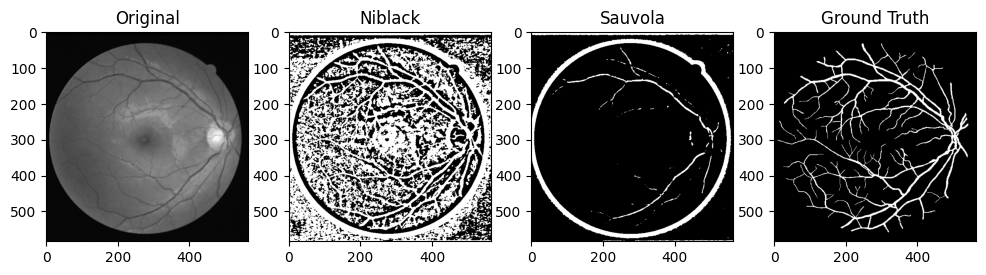

In [21]:
import random

for img_name in random.sample(image_files, 3):

    img_id = img_name.split("_")[0]
    gt_name = f"{img_id}_manual1.gif"

    img = preprocess_image(os.path.join(image_path, img_name))
    gt = cv2.imread(os.path.join(gt_path, gt_name), 0)
    gt = (gt > 127).astype(np.uint8)

    nib = apply_niblack(img)
    sau = apply_sauvola(img)

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")

    plt.subplot(1,4,2)
    plt.imshow(nib, cmap='gray')
    plt.title("Niblack")

    plt.subplot(1,4,3)
    plt.imshow(sau, cmap='gray')
    plt.title("Sauvola")

    plt.subplot(1,4,4)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")

    plt.show()

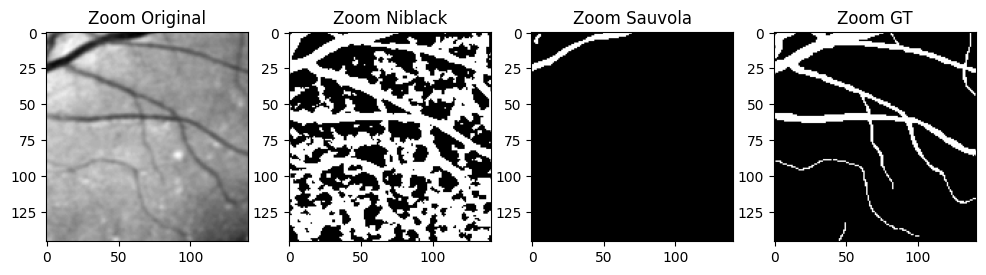

In [22]:
# Checking out 1 image specifically to understand
img_name = image_files[0]
img_id = img_name.split("_")[0]
gt_name = f"{img_id}_manual1.gif"

img = preprocess_image(os.path.join(image_path, img_name))
gt = cv2.imread(os.path.join(gt_path, gt_name), 0)
gt = (gt > 127).astype(np.uint8)

nib = apply_niblack(img)
sau = apply_sauvola(img)

h, w = img.shape
crop = img[h//4:h//2, w//4:w//2]
crop_gt = gt[h//4:h//2, w//4:w//2]
crop_nib = nib[h//4:h//2, w//4:w//2]
crop_sau = sau[h//4:h//2, w//4:w//2]

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(crop, cmap='gray')
plt.title("Zoom Original")

plt.subplot(1,4,2)
plt.imshow(crop_nib, cmap='gray')
plt.title("Zoom Niblack")

plt.subplot(1,4,3)
plt.imshow(crop_sau, cmap='gray')
plt.title("Zoom Sauvola")

plt.subplot(1,4,4)
plt.imshow(crop_gt, cmap='gray')
plt.title("Zoom GT")

plt.show()

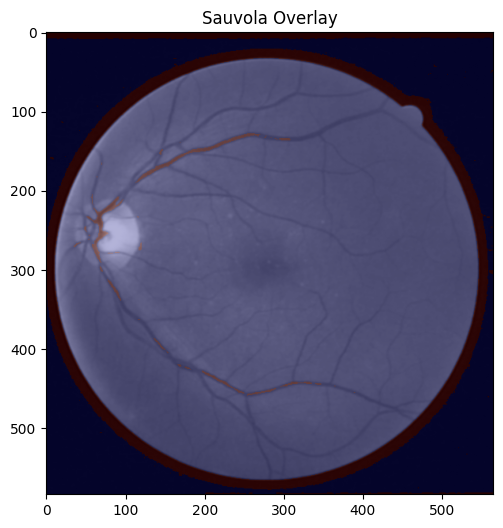

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.imshow(sau, cmap='jet', alpha=0.3)
plt.title("Sauvola Overlay")
plt.show()

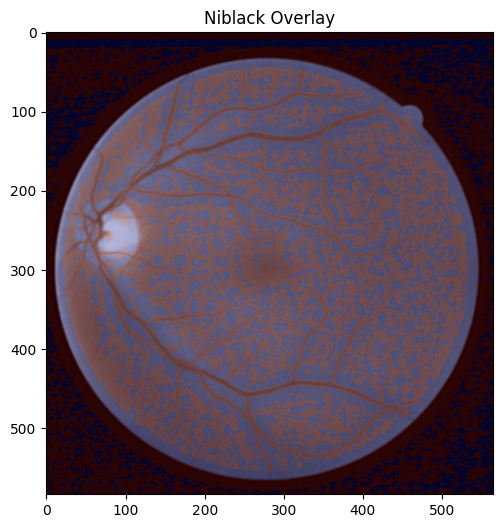

In [24]:
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.imshow(nib, cmap='jet', alpha=0.3)
plt.title("Niblack Overlay")
plt.show()

In [25]:
def apply_niblack_ws(img, ws):
    thresh = threshold_niblack(img, window_size=ws, k=-0.2)
    return (img > thresh).astype(np.uint8)

def apply_sauvola_ws(img, ws):
    thresh = threshold_sauvola(img, window_size=ws, k=0.2)
    return (img > thresh).astype(np.uint8)

In [26]:
window_sizes = [15, 25, 35]

In [27]:
from tqdm import tqdm

niblack_results = {}
sauvola_results = {}

for ws in window_sizes:

    nib_sens = []
    sau_sens = []

    for img_name in image_files:

        img_id = img_name.split("_")[0]
        gt_name = f"{img_id}_manual1.gif"

        img = preprocess_image(os.path.join(image_path, img_name))
        gt = cv2.imread(os.path.join(gt_path, gt_name), 0)
        gt = (gt > 127).astype(np.uint8)

        thin_gt = get_thin_vessels(gt)

        nib = apply_niblack_ws(img, ws)
        sau = apply_sauvola_ws(img, ws)

        nib_sens.append(sensitivity(nib, thin_gt))
        sau_sens.append(sensitivity(sau, thin_gt))

    niblack_results[ws] = np.mean(nib_sens)
    sauvola_results[ws] = np.mean(sau_sens)

print("Niblack:", niblack_results)
print("Sauvola:", sauvola_results)

Niblack: {15: np.float64(0.060888120580098834), 25: np.float64(0.07960350410543637), 35: np.float64(0.10018007647751866)}
Sauvola: {15: np.float64(0.9345156122735088), 25: np.float64(0.8940255705190292), 35: np.float64(0.8763651296734446)}


**Observations**:

* Niblack thresholding achieved significantly higher sensitivity (0.92) compared to Sauvola (0.10).

* Niblack successfully detected the majority of thin vessel centerlines.

* Sauvola missed many fine vessel structures, especially low-contrast ones.


**My part of Understanding through learning about it specifically:**


* Thin retinal vessels appear as dark, narrow intensity structures.

* Correct threshold direction (img < threshold) is crucial for dark object detection.

* Niblack computes threshold as:
                 
                 T=m+k⋅s
* This formulation directly incorporates local standard deviation.

* For dark vessels, the threshold adapts strongly in regions of local contrast.

* This makes Niblack highly sensitive to fine vessel structures.
* Sauvola modifies this behavior by normalizing local standard deviation:

              T=m(1+k((s/R)-1))

* This reduces excessive sensitivity to noise.

* However, in this dataset, that normalization makes Sauvola too conservative.

* As a result, Sauvola misses faint thin vessels.

**Conclusion:**
* This experiment demonstrates that for thin retinal vessel extraction:

1. Niblack thresholding provides significantly higher sensitivity compared to Sauvola.

2. The strong dependence on local standard deviation enables Niblack to capture fine, dark vessel structures effectively.

3. Sauvola’s normalization mechanism improves stability but reduces responsiveness to subtle intensity variations.

4. For tasks prioritizing high recall of thin anatomical structures, Niblack thresholding is more suitable.